# Fine-tuning a Vision Transformer Model With a Custom Biomedical Dataset
_Authored by: [Emre Albayrak](https://github.com/emre570)_

This guide outlines the process for fine-tuning a Vision Transformer (ViT) model on a custom biomedical dataset. It includes steps for loading and preparing the dataset, setting up image transformations for different data splits, configuring and initializing the ViT model, and defining the training process with evaluation and visualization tools.


Let's get started.

## Getting Started
First, let's install libraries first.

In [ ]:
!pip list | grep wandb


In [ ]:
!pip install datasets transformers  wandb

(Optional) We will push our model to Hugging Face Hub so we must login.

In [ ]:
#from huggingface_hub import notebook_login
#notebook_login()

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="HU0KQOY2GSY0RRF4ye5w")
project = rf.workspace("wayang-cumb2").project("wayang-classification")
version = project.version(4)
dataset = version.download("folder")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to wayang-classification-4 in folder:: 100%|██████████| 255/255 [00:00<00:00, 9305.03it/s]


## Dataset Preparation
Datasets library automatically pulls images and classes from the dataset. For detailed info, you can visit [`this link`](https://huggingface.co/docs/datasets/image_load).

In [ ]:
from datasets import load_dataset

dataset = load_dataset("wayang-classification-4")
dataset["train"][0]

Resolving data files:   0%|          | 0/162 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/47 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 0}

We got our dataset. But we don't have a validation set. To create the validation set, we will calculate the size of the validation set as a fraction of the training set based on the size of the test set. Then we split the training dataset into new training and validation subsets.

In [ ]:
# Get the numbers of each set
test_num = len(dataset["test"])
train_num = len(dataset["train"])
val_num = len(dataset["validation"])

# val_size = test_num / train_num

# train_val_split = dataset["train"].train_test_split(test_size=val_size)
# train_val_split

In [ ]:
print(train_num, val_num, test_num)

162 47 23


We got our seperated train set. Let's merge them with test set.

In [ ]:
from datasets import DatasetDict

dataset = DatasetDict({
    "train": dataset["train"],
    "validation": dataset["validation"],
    "test": dataset["test"]
})
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 162
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 47
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 23
    })
})

Perfect! Our dataset is ready. Let's assign subsets to different variables. We will use them later for easy reference.

In [ ]:
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

We can see the image is a PIL.Image with a label associated with it.

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 0}

We can also see the features of train set.

In [ ]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Beber', 'Gedog', 'Golek', 'Krucil', 'Kulit', 'Suluh'], id=None)}

Let's show one image from each class from dataset.

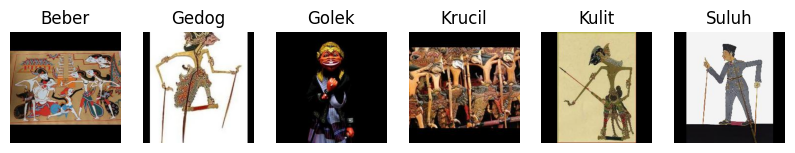

In [ ]:
import matplotlib.pyplot as plt

# Initialize a set to keep track of shown labels
shown_labels = set()

# Initialize the figure for plotting
plt.figure(figsize=(10, 10))

# Loop through the dataset and plot the first image of each label
for i, sample in enumerate(train_ds):
    label = train_ds.features['label'].names[sample['label']]
    if label not in shown_labels:
        plt.subplot(1, len(train_ds.features['label'].names), len(shown_labels) + 1)
        plt.imshow(sample['image'])
        plt.title(label)
        plt.axis('off')
        shown_labels.add(label)
        if len(shown_labels) == len(train_ds.features['label'].names):
            break

plt.show()

## Data Processing
The dataset is ready. But we are not ready for fine-tuning. We will follow this procedures respectively:

- **Label Mapping:** We convert between label IDs and their corresponding names, useful for model training and evaluation.

- **Image Processing:** Then, we utilize the ViTImageProcessor to standardize input image sizes and applies normalization specific to the pretrained model. Also, will define different transformations for training, validation, and testing to improve model generalization using torchvision.

- **Transform Functions:** Implement functions to apply the transformations to the dataset, converting images to the required format and dimensions for the ViT model.

- **Data Loading:** Set up a custom collate function to properly batch images and labels, and create a DataLoader for efficient loading and batching during model training.

- **Batch Preparation:** Retrieve and display the shape of data in a sample batch to verify correct processing and readiness for model input.

### Label Mapping

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label, id2label[train_ds[0]['label']]

({0: 'Beber', 1: 'Gedog', 2: 'Golek', 3: 'Krucil', 4: 'Kulit', 5: 'Suluh'},
 'Beber')

### Image Processing

In [ ]:
from transformers import ViTImageProcessor

model_name = "google/vit-large-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, ToTensor, Resize

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])
val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])
test_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

### Create transform functions

In [ ]:
def apply_train_transforms(examples):
    examples['pixel_values'] = [train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def apply_val_transforms(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def apply_test_transforms(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

### Apply transform functions to each set

In [ ]:
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [ ]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Beber', 'Gedog', 'Golek', 'Krucil', 'Kulit', 'Suluh'], id=None)}

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 0,
 'pixel_values': tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.1373, -0.1451, -0.1137,  ...,  0.3098,  0.3020,  0.2863],
          [-0.2549, -0.2078, -0.1216,  ...,  0.3176,  0.3098,  0.3020],
          [-0.3176, -0.2314, -0.1294,  ...,  0.3255,  0.3255,  0.3176]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.5059, -0.5765, -0.6157,  ...,  0.0431,  0.0196, -0.0118],
          [-0.5216, -0.5216, -0.4980,  ...,  0.0431,  0.0196, -0.0118],
          [-0.4667, -0.4275, -0.3647,  ...,  0.0353,  0.0196, -0.0039]]

Looks like we converted our pixel values into tensors.

### Data Loading

In [ ]:
import torch
from torch.utils.data import DataLoader

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

### Batch Preparation

In [ ]:
batch = next(iter(train_dl))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


Perfect! Now we are ready for fine-tuning process.

## Fine-tuning the Model
Now we will configure and fine-tune the model. We started by initializing the model with specific label mappings and pre-trained settings, adjusting for size mismatches. Training parameters are set up to define the model's learning process, including the save strategy, batch sizes, and training epochs, with results logged via Weights & Biases. Hugging Face Trainer will then instantiate to manage the training and evaluation, utilizing a custom data collator and the model's built-in processor. Finally, after training, the model's performance is evaluated on a test dataset, with metrics printed to assess its accuracy.

First, we call our model.

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(model_name, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([6, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There is a subtle detail in here. The `ignore_mismatched_sizes` parameter.

When you fine-tune a pre-trained model on a new dataset, sometimes the input size of your images or the model architecture specifics (like the number of labels in the classification layer) might not match exactly with what the model was originally trained on. This can happen for various reasons, such as when using a model trained on one type of image data (like natural images from ImageNet) on a completely different type of image data (like medical images or specialized camera images).

Setting `ignore_mismatched_sizes` to `True` allows the model to adjust its layers to accommodate size differences without throwing an error.

For example, the number of classes this model is trained on is 1000, which is `torch.Size([1000])` and it expects an input with `torch.Size([1000])` classes. Our dataset has 3, which is `torch.Size([3])` classes. If we give it directly, it will raise an error because the class numbers do not match.

Then, define training arguments from Google for this model.

(Optional) Note that the metrics will be saved in Weights & Biases because we set the `report_to` parameter to `wandb`. W&B will ask you for an API key, so you should create an account and an API key. If you don't want, you can remove `report_to` parameter.

In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir = "output-models",
    save_total_limit=2,
    report_to="wandb",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=40,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
)

We can now begin the fine-tuning process with `Trainer`.

In [ ]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.731873
2,No log,0.397453
3,No log,0.215888
4,No log,0.110151
5,No log,0.101637
6,No log,0.115455
7,No log,0.221744
8,No log,0.078338
9,No log,0.144337
10,No log,0.059947


TrainOutput(global_step=680, training_loss=0.0792291802518508, metrics={'train_runtime': 3776.5302, 'train_samples_per_second': 1.716, 'train_steps_per_second': 0.18, 'total_flos': 1.7751174808898765e+18, 'train_loss': 0.0792291802518508, 'epoch': 40.0})

| Epoch | Training Loss | Validation Loss | Accuracy |
|-------|---------------|-----------------|----------|
| 40    | 0.174700      | 0.596288        | 0.903846 |

The fine-tuning process is done. Let's continue with evaluating the model to test set.

In [ ]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.4044032394886017, 'test_runtime': 0.4587, 'test_samples_per_second': 50.147, 'test_steps_per_second': 13.082}


### (Optional) Push Model to Hub
We can push our model to Hugging Face Hub using `push_to_hub`

In [ ]:
model.push_to_hub("your_model_name")

That's great! Let's visualize the results.

## Results
We made the fine-tuning. Let's see how our model predicted the classes using scikit-learn's Confusion Matrix Display and show Recall Score.

### What is Confusion Matrix?
A confusion matrix is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning model, on a set of test data for which the true values are known. It's especially useful for checking how well a classification model is performing because it shows the frequency of true versus predicted labels.

Let's draw our model's Confusion Matrix

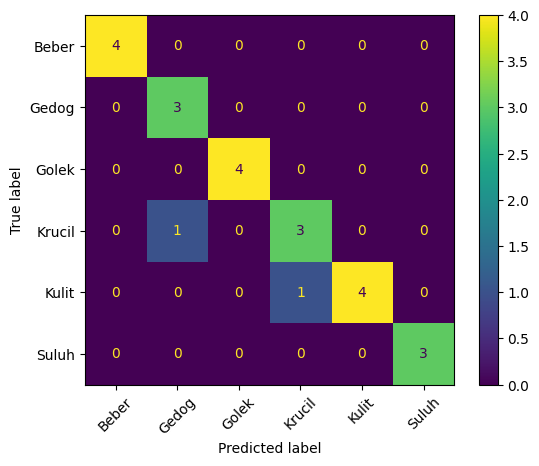

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
for i in range(len(y_true)):
  print(f"True: {labels[y_true[i]]}, Predicted: {labels[y_pred[i]]}")

True: Beber, Predicted: Beber
True: Beber, Predicted: Beber
True: Beber, Predicted: Beber
True: Beber, Predicted: Beber
True: Gedog, Predicted: Gedog
True: Gedog, Predicted: Gedog
True: Gedog, Predicted: Gedog
True: Golek, Predicted: Golek
True: Golek, Predicted: Golek
True: Golek, Predicted: Golek
True: Golek, Predicted: Golek
True: Krucil, Predicted: Krucil
True: Krucil, Predicted: Krucil
True: Krucil, Predicted: Krucil
True: Krucil, Predicted: Gedog
True: Kulit, Predicted: Kulit
True: Kulit, Predicted: Kulit
True: Kulit, Predicted: Kulit
True: Kulit, Predicted: Krucil
True: Kulit, Predicted: Kulit
True: Suluh, Predicted: Suluh
True: Suluh, Predicted: Suluh
True: Suluh, Predicted: Suluh


### What is Recall Score?
The recall score is a performance metric used in classification tasks to measure the ability of a model to correctly identify all relevant instances within a dataset. Specifically, recall assesses the proportion of actual positives that are correctly predicted as such by the model.

Let's print recall scores using scikit-learn

In [ ]:
from sklearn.metrics import recall_score

# Calculate the recall scores
# 'None' calculates recall for each class separately
recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
    print(f'Recall for {label}: {score:.2f}')


Recall for Beber: 1.00
Recall for Gedog: 1.00
Recall for Golek: 1.00
Recall for Krucil: 0.75
Recall for Kulit: 0.80
Recall for Suluh: 1.00


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

# Calculate the metrics
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)
accuracy = accuracy_score(y_true, y_pred)

table_data = []
for i in range(len(labels)):
    label = labels[i]
    table_data.append([label, precision[i], recall[i], f1[i]])
table_data.append(["Overall Accuracy",'' , '', accuracy])

# Create DataFrame
df = pd.DataFrame(table_data, columns=["Class", "Precision", "Recall", "F1-Score"])

# Print the DataFrame
display(df)


,Class,Precision,Recall,F1-Score
0,Beber,1.0,1.0,1.000000
1,Gedog,0.75,1.0,0.857143
2,Golek,1.0,1.0,1.000000
3,Krucil,0.75,0.75,0.750000
4,Kulit,1.0,0.8,0.888889
5,Suluh,1.0,1.0,1.000000
6,Overall Accuracy,,,0.913043


`Recall for benign: 0.90,
Recall for malignant: 0.86,
Recall for normal: 0.78`

In [ ]:
torch.save(model, "/content/drive/MyDrive/model.pt")

In [ ]:
from google.colab import files
files.download('/content/model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Conclusion
In this cookbook, we covered how to train a ViT model with a medical dataset. It covers crucial steps such as dataset preparation, image preprocessing, model configuration, training, evaluation, and result visualization. By leveraging Hugging Face's Transformers library scikit-learn and PyTorch Torchvision, it facilitates efficient model training and evaluation, providing valuable insights into the model's performance and its ability to classify biomedical images accurately.